# $\textit{Análisis de respuestas impulsivas}$
$\textit{Filtro lineal óptimo}$

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.signal as sp
import helper as hp
import importlib
importlib.reload(hp)

fs = 48000  # Frecuencia de muestreo
f0 = 20     # Limite inferior de frecuencias en rango audible
f1 = 20000  # limite superior de frecuencias en rango audible

# $\textit{1)}$

Para la selección de la señal de música, realizamos una búsqueda entre distintos géneros musicales y observamos el espectrograma de varias canciones. Buscamos aquella canción que contenga dentro de los 10 segundos a utilizar, la mayor cantidad de frecuencias posibles. Finalmente, elegimos la canción "Fly me to the moon" de Frank Sinatra debido a que tiene un rico contenido espectral.

Nuevamente, para la señal de voz, se utilizó el mismo criterio que para la selección de la señal de música.

In [24]:
origfs, origSignal, origpath = hp.getOriginalSignals()

In [25]:
recfs, recSignal, recpath = hp.getRecordedSignals()

/home/gullino18/Documents/Github/PASA_TP2/helper.py:36: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs1, recmusicSignal = io.wavfile.read(path[0])
/home/gullino18/Documents/Github/PASA_TP2/helper.py:37: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs2, recVoiceSignal = io.wavfile.read(path[1])
/home/gullino18/Documents/Github/PASA_TP2/helper.py:38: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs3, recchirpLinearSignal = io.wavfile.read(path[2])
/home/gullino18/Documents/Github/PASA_TP2/helper.py:39: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs4, recchirpExpSignal = io.wavfile.read(path[3])
/home/gullino18/Documents/Github/PASA_TP2/helper.py:40: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs5, recgaussSignal = io.wavfile.read(path[4])
/home/gullino18/Documents/Github/PASA_TP2/helper.py:41: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs6, recsquareSignal = io.wavfile.re

# $\textit{2)}$

Aclaracion: Las señales grabadas se sincronizaron con las originales a traves del uso de un impulso presente en el archivo reproducido que permitio alinearlas en un programa de edicion de audio. Para asegurar causalidad se dio un espacio de algunos milisegundos de adelanto para la señal original. Tambien es importante mencionar que para la estimacion de la PSD no se utilizo una ventana ya que se esta trabajando con señales limitadas en tiempo. Mas adelante se presenta una justificacion para este hecho.

Observando los gráficos de las PSDs, intuimos que la señal que mejor va funcionar para obtener h(n) es el barrido lineal porque excita al sistema con un espectro de potencia más constante en escala logarítmica que los demás. También se puede apreciar que tanto el barrido lineal y el exponencial son aquellos que menos dispersion tienen.

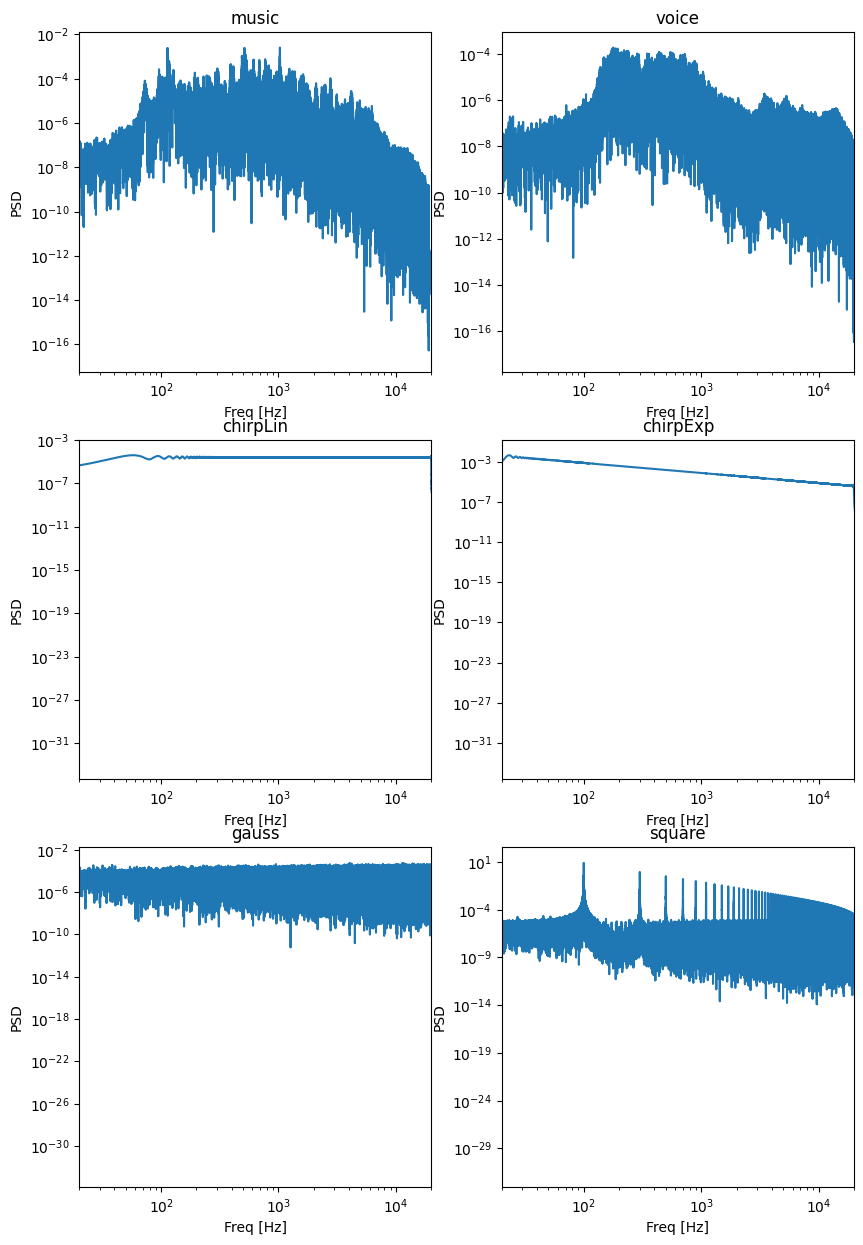

In [26]:
plt.figure(figsize=(10, 15))

for i, (name, s) in enumerate(zip(origSignal.keys(), origSignal.values())):
    f, Pxx_den = sp.periodogram(s, fs=fs, window='boxcar', nfft=hp.getNextPowerOfTwo(len(s)*5))
    plt.subplot(3, 2, i+1)
    plt.title(f"{name}")
    plt.xlabel('Freq [Hz]')
    plt.ylabel('PSD')
    plt.xlim((f0, f1))
    plt.loglog(f, Pxx_den)

$\textit{Coeficientes del filtro optimo:}$

$$ w_o = R^{-1}*p $$

Dado que las señales son reales:

$$ R = \begin{bmatrix}
Rxx(0) & Rxx (1) & ... & Rxx(M-1) \\
Rxx(1) & Rxx (0) & ... & Rxx(M-2) \\
... & & & \\

\end{bmatrix}
$$
$$ p = \begin{bmatrix}
Rxy(1) & Rxy (2) & ... & Rxy(M) \\

\end{bmatrix}
$$

# $\textit{3)}$ 

Para determinar el valor del orden óptimo M, utilizamos el criterio de que la variación porcentual entre el valor n+1 respecto al valor n sea menor al 0.05%. Utilizando este criterio, obtuvimos que el orden óptimo M = 9242. El criterio tomado se baso en observaciones de la grafica MSE vs M, donde se observo que en la mayoria de los casos estudiados en este trabajo este limite se presenta en la zona donde el MSE deja de descender rapidamente y tiende a estabilizarce.

¿Cómo podemos reducir el cálculo necesario?

Para reducir el cálculo necesario, se hizo uso de la función de scipy "solve_toeplitz" que implementa el algoritmo de Levinson–Durbin, el cúal tiene una complejidad de 
O(n^2).


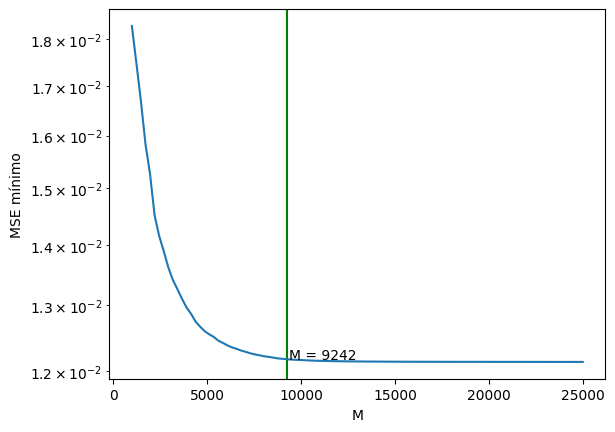

In [27]:
Ms = np.linspace(1000, 25000, 100, dtype=int)
jos = np.zeros(len(Ms))
found = False
last = 0

plt.figure()
for i, M in enumerate(Ms):
    wo, jo, nmse = hp.get_optimal_params(origSignal['chirpLin'], recSignal['chirpLin'], M)
    jos[i] = jo
    if i != 0 and last/jo-1 < 0.0005 and not found:
        plt.axvline(x=Ms[i], c='green')
        plt.text(x=Ms[i]+100, y=jo, s=f'M = {Ms[i]}')
        found = True
    last = jo

plt.xlabel('M')
plt.ylabel('MSE mínimo')
plt.semilogy(Ms, jos)

En el grafico se puede ver marcado con una linea verde el valor del M optimo

# $\textit{4)}$

Obtenemos la estimacion de h(n) para cada excitación

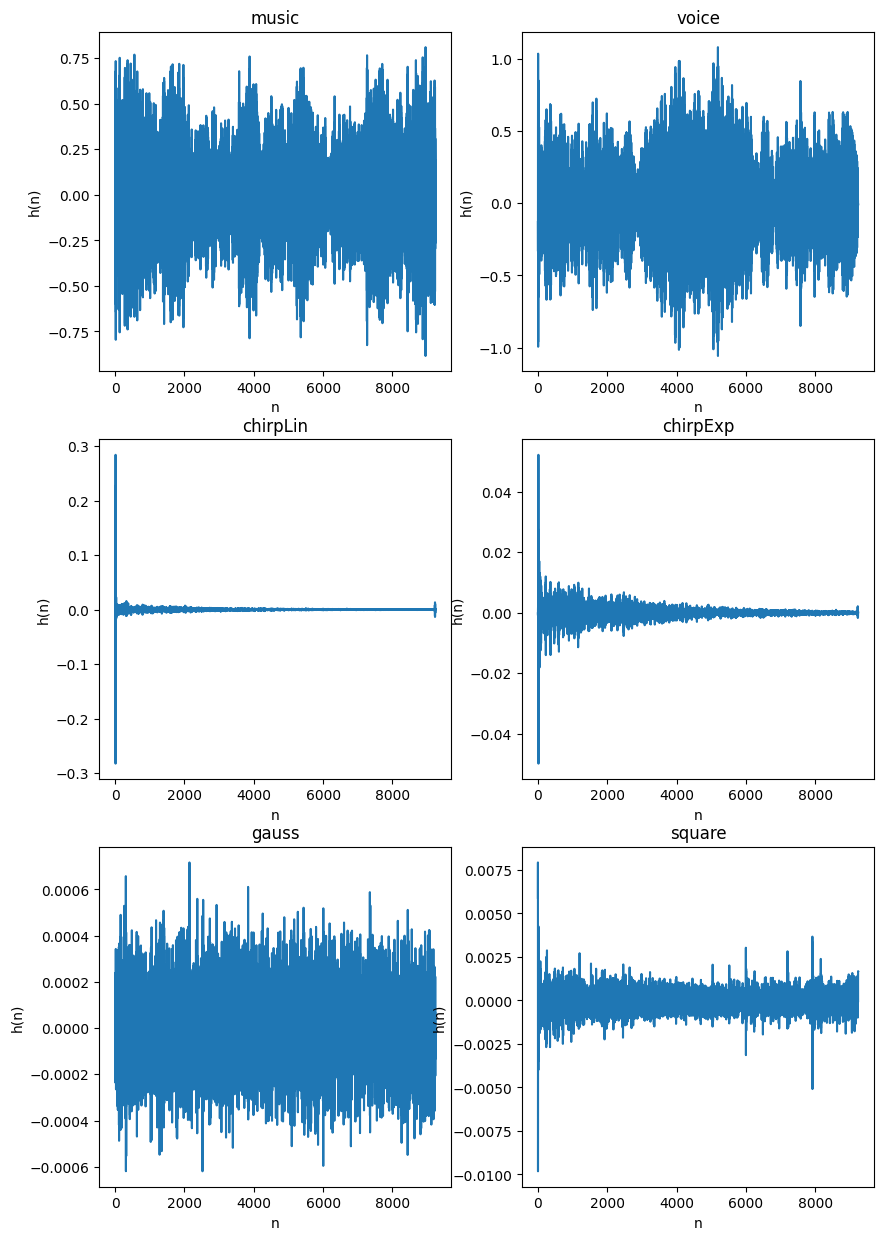

In [28]:
M = 9242 #Ordenes optimo encontrado
h_n = []
nmses = []
jos = []

plt.figure(figsize=(10, 15))
for i, (name, os, rs) in enumerate(zip(origSignal.keys(), origSignal.values(), recSignal.values())):
    h, jo, nmse = hp.get_optimal_params(os, rs, M)
    plt.subplot(3, 2, i+1)
    plt.title(f"{name}")
    plt.xlabel('n')
    plt.ylabel('h(n)')
    plt.plot(h)
    h_n.append(h)
    nmses.append(nmse)
    jos.append(jo)

plt.show()

Obtenemos la respuesta en frecuencia de cada estimacion de h(n)

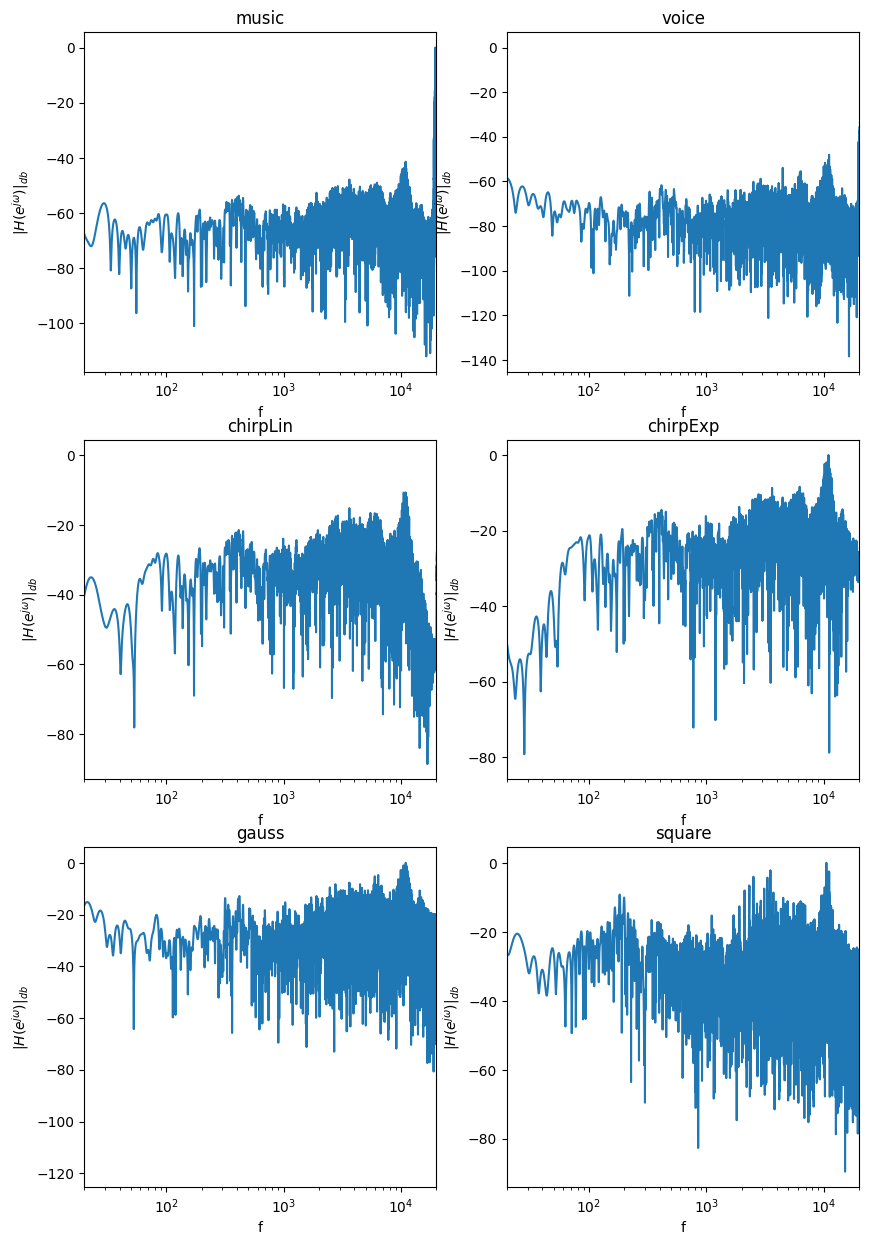

In [30]:
plt.figure(figsize=(10, 15))
for i, (name, h) in enumerate(zip(recSignal.keys(), h_n)):
    paddingLen = hp.getNextPowerOfTwo(len(h)*20)
    H = np.fft.rfft(h, paddingLen)
    f = np.fft.rfftfreq(paddingLen, 1/fs)

    plt.subplot(3, 2, i+1)
    plt.title(f"{name}")
    plt.xlabel('f')
    plt.ylabel('$|H(e^{j\omega})|_{db}$')
    plt.xlim([f0,f1])
    #plt.plot(f, 10*np.log10(np.abs(H)/abs(H).max()))
    plt.semilogx(f, 20*np.log10(np.abs(H)/abs(H).max()))
plt.show()

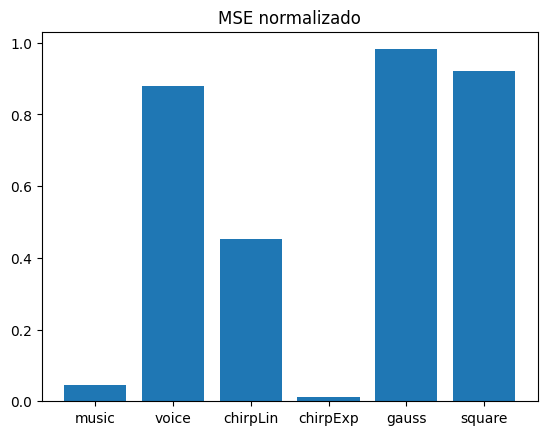

In [31]:
plt.figure()
plt.title("MSE normalizado")
plt.bar(recSignal.keys(), nmses)
plt.show()

Aclaracion: Para obtener las transformadas de las respuestas impulsivas no se utilizo ninguna ventana, solo se tomaron los pesos y se calculo la DFT. Esto es posible ya que en un sistema con respuesta FIR, esta es nula antes de la excitacion y luego de $n > (M-1)$ donde M es el orden del sistema. Si se desarrolla la DFT, se puede ver que es equivlente a la DTFT muestreada en cada punto k:

$
DTFT\{h\}(f)|_k = DFT\{h\}(k)
$

En un principio, a simple vista se puede ver que las respuestas impulsivas de ambos chirps resultan similares y resaltan en comparacion con las demas. Analizando la respuesta en frecuencia, se puede ver en todas un pico de ganancia en alrededor de 10kHz, donde hay un resaltamiento de los altos. Esto se puede notar en las mismas grabaciones, donde los ruidos agudos se sienten muy presentes. Se cree que esto es debido a la respuesta del microfono del telefono celular utilizado donde este tiene un realzamiento en esas frecuencias para un mejora en la calidad de grabacion de voz.

Nos resulto interesante el bajo MSE normalizado que tuvo la estimacion con señal de musica, y al ver el Jo este tambien resulto bajo en comparacion a las demas señales siendo este de 6,7e-4, mientras que los demas se encontraban en el orden de 1e-3 y 1e-2 a excepcion del Jo del barrido exponencial, siendo su $Jo = 1,4e-4$.

Otro resultado interesante en la señal musical es que su respuesta en frecuencia es muy similar a ambos barridos con una diferencia significativa en las frecuencias del orden de 20kHz donde se ve un pico de ganancia que alcanza los 0dB. Debido a la frecuencia donde se encuentra el efecto, probablemente no sea percibible al oido humano. 

En las señales de barrido se puede observar un efecto pasaaltos en las bajas frecuencias que no se encuentra en las demas señales, lo cual probablemente se deba a que estas estan generadas artificialmente con un ancho de banda fijo de 20Hz a 20kHz. De todas formas lo mismo se podria decir de la señal cuadrada y sin embargo esta no presenta ese efecto. En los casos donde el MSE normalizado es alto, este efecto puede verse obstruido por el nivel de ruido en la estimacion.

Otra observacion interesante es que ne las respuestas estimadas con los barridos de frecuencia se puede ver un pequeño pico de amplitud el final de la respuesta temporal. No se pudo llegar a una conclusion sobre el motivo de estos artefactos, pero se estima que puede deberse al efecto de la falta de excitacion en el rango completo de frecuencias de 0Hz a 24KHz. Esto se muestra en el espectro como un crecimiento rapido en las bandas de frecuencia que no se excitaron.

# $\textit{5)}$

En la seccion anterior se vio que la estimacion por musica resulto buena en comparacion a la mayoria de las otras, incluso mejor (en el sentido del MSE y el MSE Normalizado) que la estimacion debida al barrido lineal. Este ultimo se creia que brindaria la mejor estimacion, pero resulto ser la 3ra mejor estimacion (en el sentido del MSE normalizado). Probablemente este resultado se explique los el contenido espectral de la señal musical, que resulta rico en la banda del audio. De todasa formas se esperaba que el ruido de estimacion fuera mayor que el resultante.

En particular la mejor estimacion (en el sentido de MSE y MSE normalizado) fue lograda por el barrido exponencial, lo cual no fue inesperado, ya que se anticipaba que los barrido con su respuesta en frecuencia poco ruidosa dieran una excitacion limpia y permitan uan buena estimacion. Per oel barrido lineal fue opuesto a nuestra prediccion (por lo menos en comparacion con el barrido exponencial)



# $\textit{6)}$

En base a los graficos presentados, a simple vista se pueden descartar las estimaciones dadas por la señal de Voz, la señal cuadrada, y el ruido blanco gaussiano. Estas 3 son aquellas de mayor MSE normalizado, y ademas su respuesta impulsiva no tiene sentido fisico para un cuarto donde es los ecos son de corta duracion (como lo es el lugar donde se grabaron los ensayos). Esas respuestas impulsivas no muestran una disminucion a lo largo del tiempo y no se corresponde con el modelo fisico de ecos donde la influencia de estos disminuye a lo largo del tiempo. Es importante aclarar que la respuesta estimada con la señal cuadrada pareceria tener un pico inicial y luego drececer, permanece con una amplitud aproximadamente constante, por lo que se la agrupa con las respuestas mencionadas que no cuentan con una envolvente decreciente. 

Por otro lado se tiene la señal de musica, que a pesar de tenes un MSE normalizado de aproximadamente 0.036, su respuesta impulsiva presenta el mismo problema que las anteriores, por lo que no la consideramos una buena estimacion.

Por ultimo, el chirp lineal y exponencial son los que presentan respuestas impulsivas acordes al modelo fisico de ecos, con la distincion de que el chirp exponencial tiene ecos mucho mas significativos y presentes en comparacion al lineal. Ademas el barrido exponencial es el que presenta menor MSE normalizado, por lo que se lo considera la estimacion mas apropiada del sistema ensayado.


Utilizando esta respuesta estimada con el barrido exponencial se filtraron las distintas señales y se comparo con la grabacion. Ambos miembros del grupo notaron que el resultado fue perceptualmente aceptable y refleja los ecos percibidos en las grabaciones. La unica observacion fue que los bajos se notabaj mas apagados respecto a los agudos, incluso mas que en las grabaciones. Esto podria deberse a un exceso de amplificacion en la banda de altas frecuencias. En terminos generalos se evaluo como muy bueno al resultado del filtro.

In [32]:
# indice de h_n representa la respuesta a utilizar : 0: musica, 1: Voz, 2: barrido lineal, 3: barrido exponencial, 4: ruido blanco, 5: señal cuadrada 
result = sp.convolve(h_n[3], recSignal['music'], mode='full') / sum(recSignal['music'])

In [33]:
hp.play(recSignal["music"], recfs["music"])

In [34]:
hp.play(result, fs)